In [ ]:
%tensorflow_version 2.x

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip tiny-imagenet-200.zip

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-ima

In [ ]:
import os
import cv2
import glob
import random
import numpy as np
import tensorflow as tf
import tensorflow.keras.preprocessing.image as image_pre


from google.colab.patches import cv2_imshow

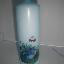

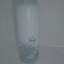

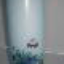

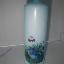

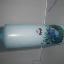

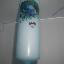

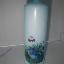

In [ ]:
#test image transformations
img = image_pre.load_img("/content/tiny-imagenet-200/test/images/test_0.JPEG")
cv2_imshow(np.array(img))
input_arr=np.array(img)
cv2_imshow(np.array(tf.image.random_contrast(input_arr, 0.2, 0.5)))
cv2_imshow(np.array(tf.image.resize(tf.image.central_crop(input_arr,0.6),[64,64])))
cv2_imshow(np.array(tf.image.random_flip_left_right(input_arr)))
cv2_imshow(np.array(tf.image.rot90(input_arr)))
cv2_imshow(np.array(tf.image.random_flip_up_down(input_arr)))
cv2_imshow(np.array(tf.image.flip_left_right(input_arr)))

Load TinyImageNet Dataset 

In [ ]:
#Load tinyImageNet Dataset
def get_classes_list():
  with open("/content/tiny-imagenet-200/wnids.txt") as file:
    classes = file.readlines()
    wind_names = list()
    index = 0
    for className in classes:
      wind_names.append(className.rstrip())
      index +=1 
  return wind_names
class_names = get_classes_list()
print(class_names)


['n02124075', 'n04067472', 'n04540053', 'n04099969', 'n07749582', 'n01641577', 'n02802426', 'n09246464', 'n07920052', 'n03970156', 'n03891332', 'n02106662', 'n03201208', 'n02279972', 'n02132136', 'n04146614', 'n07873807', 'n02364673', 'n04507155', 'n03854065', 'n03838899', 'n03733131', 'n01443537', 'n07875152', 'n03544143', 'n09428293', 'n03085013', 'n02437312', 'n07614500', 'n03804744', 'n04265275', 'n02963159', 'n02486410', 'n01944390', 'n09256479', 'n02058221', 'n04275548', 'n02321529', 'n02769748', 'n02099712', 'n07695742', 'n02056570', 'n02281406', 'n01774750', 'n02509815', 'n03983396', 'n07753592', 'n04254777', 'n02233338', 'n04008634', 'n02823428', 'n02236044', 'n03393912', 'n07583066', 'n04074963', 'n01629819', 'n09332890', 'n02481823', 'n03902125', 'n03404251', 'n09193705', 'n03637318', 'n04456115', 'n02666196', 'n03796401', 'n02795169', 'n02123045', 'n01855672', 'n01882714', 'n02917067', 'n02988304', 'n04398044', 'n02843684', 'n02423022', 'n02669723', 'n04465501', 'n02165456'

In [ ]:
training_files  = list()
all_files = glob.glob(f"/content/tiny-imagenet-200/train/*/images/*.JPEG")
for file_path in all_files:
    found_class = False
    class_index = 0
    for class_name in class_names:
        if class_name in file_path:
            training_files.append((file_path,class_name,class_index, os.path.basename(file_path)))
            found_class = True
        class_index += 1
        if(found_class):
            break
np.random.shuffle(training_files)

In [ ]:
validation_gt = list()
with open("/content/tiny-imagenet-200/val/val_annotations.txt") as file:
    validation_data = file.readlines()
    for val in validation_data:
      #file_name, class_index, class_name
      file_path = "/content/tiny-imagenet-200/val/images/"
      validation_gt.append((file_path+val.split("\t")[0],
                            val.split("\t")[1],
                            class_names.index(val.split("\t")[1]),
                            val.split("\t")[0]))

In [ ]:
#Data Generator Class
class AgumentedDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, train_dataset,
                 batch_size=32, 
                 dims=(64,64,3),
                 number_of_classes=200,
                 isTraining = True):
        
        self.dims = dims
        self.batch_size = batch_size
        self.train_dataset = train_dataset
        self.n_classes = number_of_classes
        self.is_training = isTraining
        self.on_epoch_end()

    def __len__(self):
        return len(self.train_dataset) // self.batch_size

    def __getitem__(self, index):
        total_items = self.total_items[index*self.batch_size:(index+1)*self.batch_size]
        image_ids = [self.train_dataset[k] for k in total_items]
        _x, _y = self.get_data_set(image_ids)
        return _x, _y

    def on_epoch_end(self):
        self.total_items = np.arange(len(self.train_dataset))
        np.random.shuffle(self.total_items)

    def get_data_set(self, training_files_tuples):
        X = np.empty((self.batch_size, *self.dims))
        y = np.empty((self.batch_size), dtype=int)

        for i,(path,class_name,class_index,file_name) in enumerate(training_files_tuples):
            image_path = path
            image = tf.keras.preprocessing.image.load_img(image_path)
            input_arr = tf.keras.preprocessing.image.img_to_array(image)
            input_arr = np.array([input_arr])
            if(self.is_training):
              random_int = random.randint(1,6)
              if(random_int is 1):
                  input_arr = np.array(tf.image.random_contrast(input_arr, 0.2, 0.5))
              elif(random_int is 2):
                  input_arr = np.array(tf.image.resize(tf.image.central_crop(input_arr,0.6),[64,64]))
              elif(random_int is 3):
                  input_arr = np.array(tf.image.random_flip_left_right(input_arr))
              elif(random_int is 4):
                  input_arr = np.array(tf.image.random_flip_up_down(input_arr))
              else:
                input_arr = np.array(tf.image.flip_left_right(input_arr))

            X[i,] = input_arr

            y[i] = int(class_index)
            
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Rescaling, GlobalAveragePooling2D,\
BatchNormalization, MaxPooling2D, ReLU, concatenate, dot, Softmax, Input, Activation, Reshape, Dot, Multiply,\
ZeroPadding2D, Add
import keras.backend as K




In [ ]:
datagenerator = AgumentedDataGenerator(np.array(training_files),
                                       dims=(64,64,3))

val_datagenerator = AgumentedDataGenerator(np.array(validation_gt),
                                       dims=(64,64,3),isTraining=False)



model = models.Sequential()
model.add(Rescaling(1.0 / 255, input_shape=(64, 64, 3)))
model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3),padding='same')) #, activation='relu'
model.add(BatchNormalization(axis=-1))
model.add(ReLU())
model.add(Conv2D(32, (3, 3),padding='same')) #, activation='relu'
model.add(BatchNormalization(axis=-1))
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))   

model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   

model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(1, 1))) 

model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(200, activation='softmax'))

#Early Stopping Callback
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

#learning_decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

#Model Checkpointing
checkpoint_filepath = '/content/saved_model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


model.compile(loss='categorical_crossentropy', 
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))

print(model.summary())



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_14 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
re_lu_5 (ReLU)               (None, 64, 64, 32)       

In [ ]:

history = model.fit(datagenerator, epochs=20, 
                    validation_data=val_datagenerator,
                    callbacks=[es_callback,model_checkpoint_callback])


Epoch 1/20
3125/3125 [==============================] - 365s 116ms/step - loss: 5.0949 - accuracy: 0.0249 - val_loss: 5.0453 - val_accuracy: 0.0382
INFO:tensorflow:Assets written to: /content/saved_model/assets
Epoch 2/20
3125/3125 [==============================] - 361s 115ms/step - loss: 4.6279 - accuracy: 0.0552 - val_loss: 4.7303 - val_accuracy: 0.0631
INFO:tensorflow:Assets written to: /content/saved_model/assets
Epoch 3/20
3125/3125 [==============================] - 368s 118ms/step - loss: 4.2542 - accuracy: 0.0954 - val_loss: 4.0014 - val_accuracy: 0.1406
INFO:tensorflow:Assets written to: /content/saved_model/assets
Epoch 4/20
3125/3125 [==============================] - 367s 118ms/step - loss: 3.9705 - accuracy: 0.1340 - val_loss: 3.8428 - val_accuracy: 0.1768
INFO:tensorflow:Assets written to: /content/saved_model/assets
Epoch 5/20
3125/3125 [==============================] - 362s 116ms/step - loss: 3.7364 - accuracy: 0.1698 - val_loss: 3.5758 - val_accuracy: 0.2175
INFO:ten

### PART 2
Resnet 18 Model

In [ ]:
def default_bn_params(scale=True):
    default_bn_params = {
        'axis': 3,
        'momentum': 0.99,
        'epsilon': 2e-5,
        'center': True,
        'scale': scale,
    }
    return default_bn_params

def default_conv_params():
    default_conv_params = {
        'kernel_initializer': 'he_uniform',
        'use_bias': False,
        'padding': 'valid',
        }
    return default_conv_params

def handle_block_names(stage, block):
    name_base = 'stage{}_unit{}_'.format(stage + 1, block + 1)
    conv_name = name_base + 'conv'
    bn_name = name_base + 'bn'
    relu_name = name_base + 'relu'
    sc_name = name_base + 'sc'
    return conv_name, bn_name, relu_name, sc_name

def resnet_block(filters,stage, block, addcubs=False, cubs=0, strides=(1,1), cut='pre'):
    conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)
    def layer(input_tensor):
        x = BatchNormalization(name=bn_name + '1', **default_bn_params())(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)

        # defining shortcut connection
        if cut == 'pre':
            shortcut = input_tensor
        elif cut == 'post':
            shortcut = layers.Conv2D(filters, (1, 1), name=sc_name, strides=strides, **default_conv_params())(x)
      
        
     
        # continue with convolution layers
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '1', **default_conv_params())(x)

        x = BatchNormalization(name=bn_name + '2', **default_bn_params())(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **default_conv_params())(x)
        if cubs == 1 and addcubs:
          cubsoutput1 = CubsBlock1(x,filters)
          cubsoutput2 = CubsBlock2(x,filters)
          x = tf.add(cubsoutput1,cubsoutput2)
        elif cubs == 2 and addcubs:
          x = CubsBlock1(x,filters)
          x = CubsBlock2(x,filters)
        elif cubs == 3 and addcubs:
          x = CubsBlock2(x,filters)
          x = CubsBlock1(x,filters)

        # add residual connection
        x = Add()([x, shortcut])
        return x
    return layer


In [ ]:
init_filters = 64
img_input = Input(shape=(64,64,3), name='data')
x = BatchNormalization(name='bn_data', **default_bn_params(False))(img_input)
x = ZeroPadding2D(padding=(3, 3))(x)

x = Conv2D(init_filters, (7, 7), strides=(2, 2), name='conv0', **default_conv_params())(x)
x = BatchNormalization(name='bn0', **default_bn_params())(x)
x = Activation('relu', name='relu0')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pooling0')(x)
# resnet body
for stage, rep in enumerate((2,2,2,2)):
    filters = init_filters * (2 ** stage)
    for block in range(rep):
        
        # first block of first stage without strides because we have maxpooling before
        if block == 0 and stage == 0:
            x = resnet_block(filters, stage, block, strides=(1, 1),cut='post')(x)
        elif block == 0:
            x = resnet_block(filters, stage, block, strides=(2, 2),cut='post')(x)
        else:
            x = resnet_block(filters, stage, block, strides=(1, 1),cut='pre')(x)

x = BatchNormalization(name='bn1', **default_bn_params())(x)
x = Activation('relu', name='relu1')(x)

x = layers.GlobalAveragePooling2D(name='pool1')(x)
x = layers.Dense(200, name='fc1')(x)
x = layers.Activation('softmax', name='softmax')(x)

model = models.Model(img_input,x)

model.summary()
datagenerator = AgumentedDataGenerator(np.array(training_files),
                                       dims=(64,64,3))

val_datagenerator = AgumentedDataGenerator(np.array(validation_gt),
                                       dims=(64,64,3),isTraining=False)

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])


history = model.fit(datagenerator, epochs=10, validation_data=val_datagenerator)


### PART 3 
Augment with CUBS blocks as given.



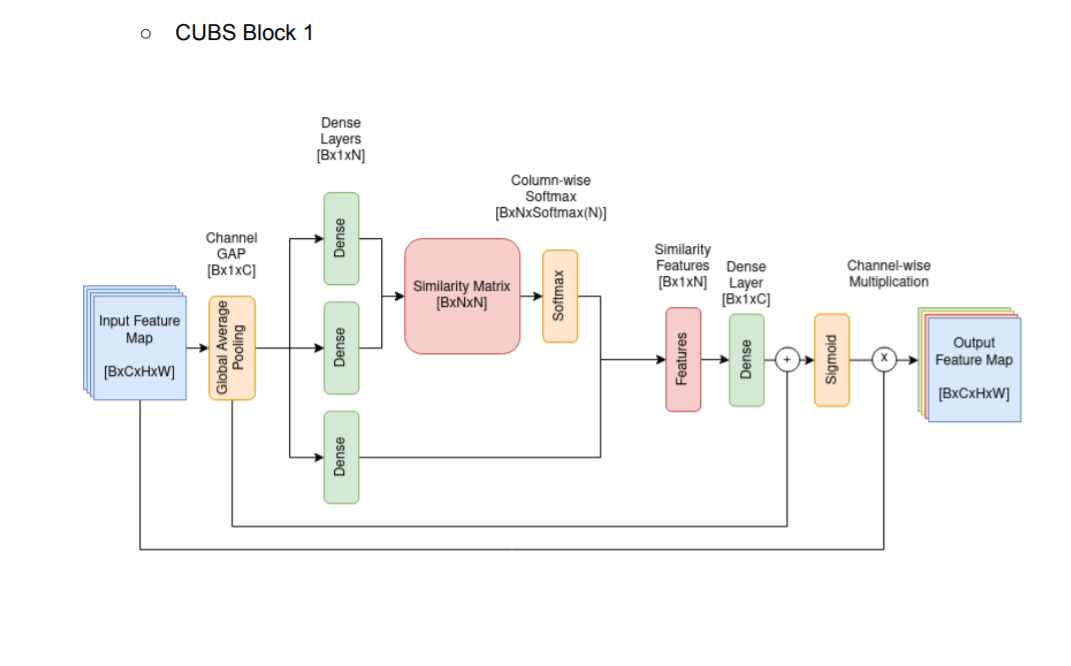

In [ ]:
def CubsBlock1(input,filters):
  avg_pool=GlobalAveragePooling2D(data_format='channels_last')(input)
  print("avg_pool :: ",avg_pool.shape)
  
  agv_pool_reshaped = Reshape((1,filters))(avg_pool)
  print("agv_pool_reshaped :: ",agv_pool_reshaped.shape)

  d1_out = Dense(512,activation='relu')(agv_pool_reshaped)
  d2_out = Dense(512,activation='relu')(agv_pool_reshaped)
  d3_out = Dense(512,activation='relu')(agv_pool_reshaped)
  print("d1_out :: ", d1_out.shape)
  print("d2_out :: ", d2_out.shape)
  print("d3_out :: ", d3_out.shape)
  out = Dot(axes=[1,2],normalize=True)([d1_out,tf.transpose(d2_out,perm=[0,2,1])])
  print("out :: ",out.shape)

  sf_m_out = tf.keras.activations.softmax(out,axis=2)
  print("sf_m_out :: ",sf_m_out.shape)

  # dt= tf.keras.backend.sum(sf_m_out * d3_out,axis=-1,keepdims=True)
  # print(dt.shape)

  d3_dot_sf = Dot(axes=[1,2])([sf_m_out,d3_out])
  print("d3_dot_sf :: ",d3_dot_sf.shape)

  d3_dot_sf_reshaped = Reshape((1,512))(d3_dot_sf)

  print("d3_dot_sf_reshaped :: ",d3_dot_sf_reshaped.shape)
  d4_out = Dense(filters)(d3_dot_sf_reshaped)

  print("d4_out :: ",d4_out.shape)
  add_cell = tf.add(d4_out,agv_pool_reshaped)

  sig_out = tf.keras.activations.sigmoid(add_cell)

  print("sig_out :: ",sig_out.shape)
  cubsOutput = Multiply()([input,sig_out])
  print("Cubsout1", cubsOutput.shape)
  return cubsOutput



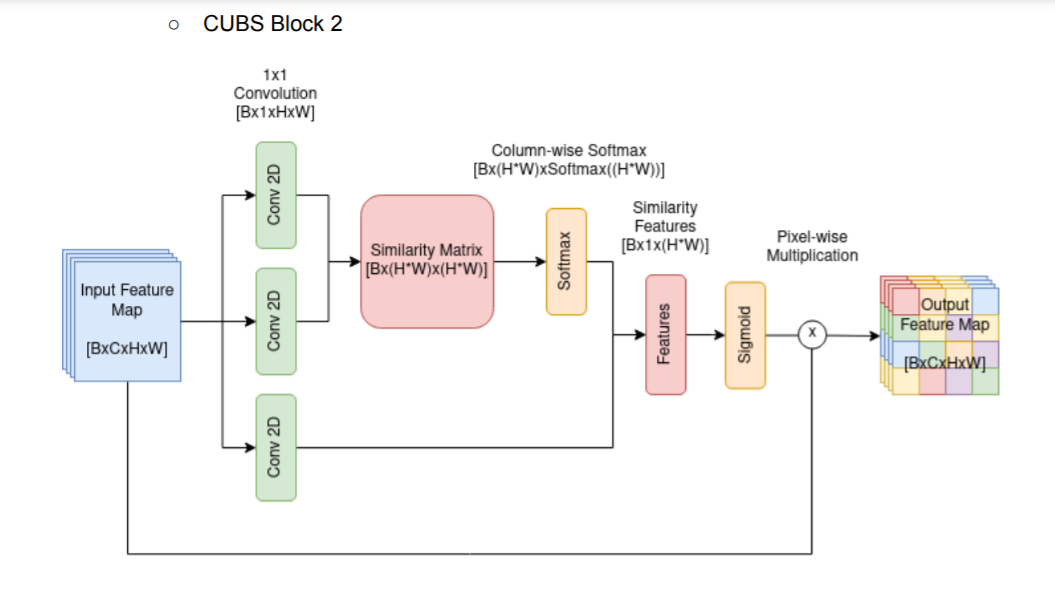

In [ ]:
def CubsBlock2(input,filters):
  
  conv1_out = Conv2D(1, (1,1), padding='same', activation='relu')(input)
  conv2_out = Conv2D(1, (1,1), padding='same', activation='relu')(input)
  conv3_out = Conv2D(1, (1,1), padding='same', activation='relu')(input)
  print("d1_out :: ", conv1_out.shape)
  print("d2_out :: ", conv2_out.shape)
  print("d3_out :: ", conv3_out.shape)
  #transp = tf.transpose(conv2_out, perm=[0,3,2,1])
  #print(transp.shape)
  # print(Reshape(1,)(Flatten()(conv1_out)))
  print(conv1_out.shape[1])
  conv1_out = Flatten()(conv1_out)
  conv2_out = Flatten()(conv2_out)
  conv_shape = conv3_out.shape[1:3]
  conv3_out = Flatten()(conv1_out)
  print("Conv shape", conv2_out.shape, conv_shape)
  out = Dot(axes=[1,2],normalize=True)([Reshape((1,conv_shape[0]*conv_shape[1]))(conv1_out),Reshape((conv_shape[0]*conv_shape[1],1))(conv2_out)])
  print("out :: ",out.shape)

  #out = K.batch_dot(conv1_out,conv2_out, axes=[1,2])

  sf_m_out = tf.keras.activations.softmax(out,axis=2)
  print("sf_m_out :: ",sf_m_out.shape)

  # dt= tf.keras.backend.sum(sf_m_out * d3_out,axis=-1,keepdims=True)
  # print(dt.shape)

  d3_dot_sf = Dot(axes=1)([sf_m_out,tf.transpose(Reshape((1,conv_shape[0]*conv_shape[1]))(conv3_out), perm=[0,2,1])])
  print("d3_dot_sf :: ",d3_dot_sf.shape)

  d3_dot_sf_reshaped = Reshape((1,conv_shape[0]*conv_shape[1]))(d3_dot_sf)

  print("d3_dot_sf_reshaped :: ",d3_dot_sf_reshaped.shape)
  #d4_out = Dense(filters)(d3_dot_sf_reshaped)

  #print("d4_out :: ",d4_out.shape)
  #add_cell = tf.add(d4_out,agv_pool_reshaped)

  sig_out = tf.keras.activations.sigmoid(d3_dot_sf_reshaped)

  print("sig_out :: ",sig_out.shape)
  sig_out = Reshape((conv_shape[0],conv_shape[1],1))(sig_out)
  cubsOutput = Multiply()([input,sig_out])
  print("Cubsout2", cubsOutput.shape)
  return cubsOutput

In [ ]:
def TrainCubs(cubs):

    init_filters = 64
    img_input = Input(shape=(64,64,3), name='data')
    x = BatchNormalization(name='bn_data', **default_bn_params(False))(img_input)
    x = ZeroPadding2D(padding=(3, 3))(x)

    x = Conv2D(init_filters, (7, 7), strides=(2, 2), name='conv0', **default_conv_params())(x)
    x = BatchNormalization(name='bn0', **default_bn_params())(x)
    x = Activation('relu', name='relu0')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pooling0')(x)
    # resnet body
    
    for stage, rep in enumerate((2,2,2,2)):
      i = 0
      addcubs = False
      filters = init_filters * (2 ** stage)
      for block in range(rep):
          i += 1
          if i == 2:
            addcubs = True
          # first block of first stage without strides because we have maxpooling before
          if block == 0 and stage == 0:
              x = resnet_block(filters, stage, block, addcubs, cubs, strides=(1, 1), cut='post')(x)
          elif block == 0:
              x = resnet_block(filters, stage, block, addcubs, cubs, strides=(2, 2), cut='post')(x)
          else:
              x = resnet_block(filters, stage, block, addcubs, cubs, strides=(1, 1), cut='pre')(x)

    x = BatchNormalization(name='bn1', **default_bn_params())(x)
    x = Activation('relu', name='relu1')(x)
    x = layers.GlobalAveragePooling2D(name='pool1')(x)
    x = layers.Dense(200, name='fc1')(x)
    x = layers.Activation('softmax', name='softmax')(x)

    model = models.Model(img_input,x)

    model.summary()
    datagenerator = AgumentedDataGenerator(np.array(training_files),
                                          dims=(64,64,3))

    val_datagenerator = AgumentedDataGenerator(np.array(validation_gt),
                                          dims=(64,64,3),isTraining=False)

    model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])


    history = model.fit(datagenerator, epochs=10, validation_data=val_datagenerator)


In [ ]:
TrainCubs(1)

avg_pool ::  (None, 64)
agv_pool_reshaped ::  (None, 1, 64)
d1_out ::  (None, 1, 512)
d2_out ::  (None, 1, 512)
d3_out ::  (None, 1, 512)
out ::  (None, 512, 512)
sf_m_out ::  (None, 512, 512)
d3_dot_sf ::  (None, 512, 1)
d3_dot_sf_reshaped ::  (None, 1, 512)
d4_out ::  (None, 1, 64)
sig_out ::  (None, 1, 64)
Cubsout1 (None, 16, 16, 64)
d1_out ::  (None, 16, 16, 1)
d2_out ::  (None, 16, 16, 1)
d3_out ::  (None, 16, 16, 1)
16
Conv shape (None, 256) (16, 16)
out ::  (None, 256, 256)
sf_m_out ::  (None, 256, 256)
d3_dot_sf ::  (None, 256, 1)
d3_dot_sf_reshaped ::  (None, 1, 256)
sig_out ::  (None, 1, 256)
Cubsout2 (None, 16, 16, 64)
avg_pool ::  (None, 128)
agv_pool_reshaped ::  (None, 1, 128)
d1_out ::  (None, 1, 512)
d2_out ::  (None, 1, 512)
d3_out ::  (None, 1, 512)
out ::  (None, 512, 512)
sf_m_out ::  (None, 512, 512)
d3_dot_sf ::  (None, 512, 1)
d3_dot_sf_reshaped ::  (None, 1, 512)
d4_out ::  (None, 1, 128)
sig_out ::  (None, 1, 128)
Cubsout1 (None, 8, 8, 128)
d1_out ::  (None, 8,

KeyboardInterrupt: ignored

In [ ]:
TrainCubs(2)

avg_pool ::  (None, 64)
agv_pool_reshaped ::  (None, 1, 64)
d1_out ::  (None, 1, 512)
d2_out ::  (None, 1, 512)
d3_out ::  (None, 1, 512)
out ::  (None, 512, 512)
sf_m_out ::  (None, 512, 512)
d3_dot_sf ::  (None, 512, 1)
d3_dot_sf_reshaped ::  (None, 1, 512)
d4_out ::  (None, 1, 64)
sig_out ::  (None, 1, 64)
Cubsout1 (None, 16, 16, 64)
d1_out ::  (None, 16, 16, 1)
d2_out ::  (None, 16, 16, 1)
d3_out ::  (None, 16, 16, 1)
16
Conv shape (None, 256) (16, 16)
out ::  (None, 256, 256)
sf_m_out ::  (None, 256, 256)
d3_dot_sf ::  (None, 256, 1)
d3_dot_sf_reshaped ::  (None, 1, 256)
sig_out ::  (None, 1, 256)
Cubsout2 (None, 16, 16, 64)
avg_pool ::  (None, 128)
agv_pool_reshaped ::  (None, 1, 128)
d1_out ::  (None, 1, 512)
d2_out ::  (None, 1, 512)
d3_out ::  (None, 1, 512)
out ::  (None, 512, 512)
sf_m_out ::  (None, 512, 512)
d3_dot_sf ::  (None, 512, 1)
d3_dot_sf_reshaped ::  (None, 1, 512)
d4_out ::  (None, 1, 128)
sig_out ::  (None, 1, 128)
Cubsout1 (None, 8, 8, 128)
d1_out ::  (None, 8,

In [ ]:
TrainCubs(3)

d1_out ::  (None, 16, 16, 1)
d2_out ::  (None, 16, 16, 1)
d3_out ::  (None, 16, 16, 1)
16
Conv shape (None, 256) (16, 16)
out ::  (None, 256, 256)
sf_m_out ::  (None, 256, 256)
d3_dot_sf ::  (None, 256, 1)
d3_dot_sf_reshaped ::  (None, 1, 256)
sig_out ::  (None, 1, 256)
Cubsout2 (None, 16, 16, 64)
avg_pool ::  (None, 64)
agv_pool_reshaped ::  (None, 1, 64)
d1_out ::  (None, 1, 512)
d2_out ::  (None, 1, 512)
d3_out ::  (None, 1, 512)
out ::  (None, 512, 512)
sf_m_out ::  (None, 512, 512)
d3_dot_sf ::  (None, 512, 1)
d3_dot_sf_reshaped ::  (None, 1, 512)
d4_out ::  (None, 1, 64)
sig_out ::  (None, 1, 64)
Cubsout1 (None, 16, 16, 64)
d1_out ::  (None, 8, 8, 1)
d2_out ::  (None, 8, 8, 1)
d3_out ::  (None, 8, 8, 1)
8
Conv shape (None, 64) (8, 8)
out ::  (None, 64, 64)
sf_m_out ::  (None, 64, 64)
d3_dot_sf ::  (None, 64, 1)
d3_dot_sf_reshaped ::  (None, 1, 64)
sig_out ::  (None, 1, 64)
Cubsout2 (None, 8, 8, 128)
avg_pool ::  (None, 128)
agv_pool_reshaped ::  (None, 1, 128)
d1_out ::  (None, 1

KeyboardInterrupt: ignored

In [ ]:
import scipy.io as sio
import glob
import os
import numpy as np
import glob
!wget http://ai.stanford.edu/~jkrause/car196/cars_train.tgz
!tar -xzvf "cars_train.tgz"

!wget https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
!tar -xzvf "car_devkit.tgz"

Streaming output truncated to the last 5000 lines.
cars_train/03163.jpg
cars_train/03164.jpg
cars_train/03165.jpg
cars_train/03166.jpg
cars_train/03167.jpg
cars_train/03168.jpg
cars_train/03169.jpg
cars_train/03170.jpg
cars_train/03171.jpg
cars_train/03172.jpg
cars_train/03173.jpg
cars_train/03174.jpg
cars_train/03175.jpg
cars_train/03176.jpg
cars_train/03177.jpg
cars_train/03178.jpg
cars_train/03179.jpg
cars_train/03180.jpg
cars_train/03181.jpg
cars_train/03182.jpg
cars_train/03183.jpg
cars_train/03184.jpg
cars_train/03185.jpg
cars_train/03186.jpg
cars_train/03187.jpg
cars_train/03188.jpg
cars_train/03189.jpg
cars_train/03190.jpg
cars_train/03191.jpg
cars_train/03192.jpg
cars_train/03193.jpg
cars_train/03194.jpg
cars_train/03195.jpg
cars_train/03196.jpg
cars_train/03197.jpg
cars_train/03198.jpg
cars_train/03199.jpg
cars_train/03200.jpg
cars_train/03201.jpg
cars_train/03202.jpg
cars_train/03203.jpg
cars_train/03204.jpg
cars_train/03205.jpg
cars_train/03206.jpg
cars_train/03207.jpg
cars

In [ ]:
cars_meta = sio.loadmat('/content/devkit/cars_meta.mat')
cars_train_annos = sio.loadmat('/content/devkit/cars_train_annos.mat')
class_preds = np.loadtxt('/content/devkit/train_perfect_preds.txt')
files = glob.glob('/content/cars_train/*.jpg')

In [ ]:
train_data = list()
for i in range(len(class_preds)):
    file_name = os.path.basename(files[i])
    bbox_x1,bbox_x2,bbox_y1,bbox_y2 = cars_train_annos['annotations'][0][i]['bbox_x1'][0][0],\
        cars_train_annos['annotations'][0][i]['bbox_x2'][0][0],\
            cars_train_annos['annotations'][0][i]['bbox_y1'][0][0],\
                cars_train_annos['annotations'][0][i]['bbox_y2'][0][0]
    class_name = cars_meta['class_names'][0][int(class_preds[i]-1)][0]
    class_index = int(class_preds[i])-1
    file_path = files[i]
    train_data.append((file_path,class_name,class_index,file_name,(bbox_x1,bbox_x2,bbox_y1,bbox_y2)))
train_data.sort(key=lambda x:x[1])
#print(train_data)


class_98_data = list()
rest_class_98_data = list()
for item in train_data:
  (path,class_name,class_index,file_name,bbox) = item
  if (class_index> 97):
    rest_class_98_data.append(item)
  else:
    class_98_data.append(item)

print(class_98_data)


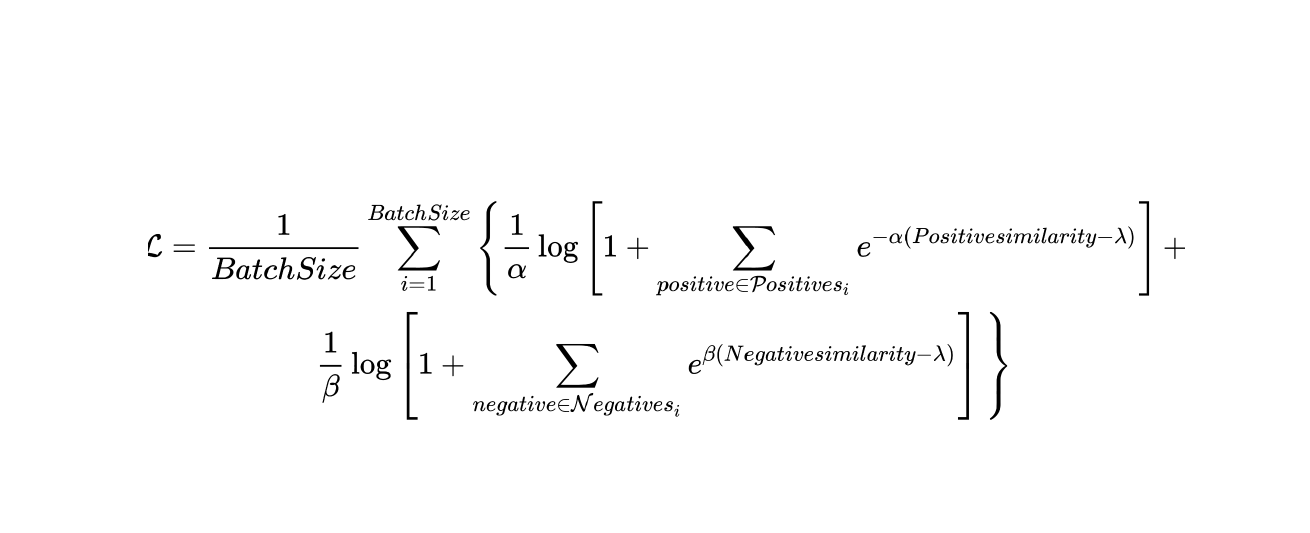

Loss Function Implementation

In [ ]:
def cubs_loss_function(x_pred,y_pred):
  batch_size = x_pred.shape[0]
  alpha = 5 #range 1 - 10
  beta = 50 #range 40-60
  lambda_ = 0.5 #range 0 - 1
  term1 = 0
  inner_term1 = 0
  inner_term1_sum = 0

  anchor, positive, negative = y_pred[:,:98], y_pred[:,98:2*98], y_pred[:,2*98:]
  positives = tf.reduce_mean(tf.square(anchor - positive), axis=1)
  negatives = tf.reduce_mean(tf.square(anchor - negative), axis=1)
  
  for positive_similarity in positives:
    inner_term1_sum += np.exp(-alpha*(positive_similarity - lambda_))
  
  inner_term2_sum = 0
  for negative_similarity in negatives:
    inner_term2_sum += np.exp(beta *(negative_similarity - lambda_))

  for i in range(batch_size):
    term1 += ((1/alpha)* np.log(1 + inner_term1_sum)) + (1/beta)*np.log(1+ inner_term2_sum)
  
  return (1/batch_size)*term1

In [ ]:
class AgumentedDataGenerator_cars(tf.keras.utils.Sequence):
    def __init__(self, train_dataset,
                 batch_size=32, 
                 dims=(228,228,3),
                 number_of_classes=200,
                 isTraining = True):
        
        self.dims = dims
        self.batch_size = batch_size
        self.train_dataset = train_dataset
        self.n_classes = number_of_classes
        self.is_training = isTraining
        self.on_epoch_end()
        self.temp_arr = []
        for index, item in enumerate(class_98_data):
          (path,class_name,class_index_,file_name,bbox) = item
          self.temp_arr.append(class_index_)
        self.temp_arr = np.asarray(self.temp_arr)

    def __len__(self):
        return len(self.train_dataset) // self.batch_size

    def __getitem__(self, index):
        total_items = self.total_items[index*self.batch_size:(index+1)*self.batch_size]
        image_ids = [self.train_dataset[k] for k in total_items]
        _x, _y = self.get_data_set(image_ids)
        return _x, _y

    def on_epoch_end(self):
        self.total_items = np.arange(len(self.train_dataset))
        np.random.shuffle(self.total_items)

    def get_data_set(self, training_files_tuples):
        anchors = np.empty((self.batch_size, *self.dims))
        positives = np.empty((self.batch_size, *self.dims))
        negatives = np.empty((self.batch_size, *self.dims))
        y_pred = np.empty((self.batch_size, 3*98))

        

        for i in range(0, self.batch_size):
          # We need to find an anchor, a positive example and a negative example
          index = random.randint(0, len(class_98_data) - 1)
          anchor = class_98_data[index]
          #y = y_train[index]
          #print(anchor)
          (path,class_name,t_class_index,file_name,bbox) =anchor
          
          
          positive_indexes = np.squeeze(np.where(self.temp_arr == t_class_index))
          negative_indexes = np.squeeze(np.where(self.temp_arr != t_class_index))
         
          x_positive = class_98_data[positive_indexes[random.randint(0, len(positive_indexes) - 1)]]
          x_negative = class_98_data[negative_indexes[random.randint(0, len(negative_indexes) - 1)]]
         
          image = tf.keras.preprocessing.image.load_img(anchor[0])
          input_arr = tf.keras.preprocessing.image.img_to_array(image)
          x_anchor = np.array([input_arr])
          x_anchor = tf.image.resize(x_anchor, [228,228])
         
          image = tf.keras.preprocessing.image.load_img(x_positive[0])
          input_arr = tf.keras.preprocessing.image.img_to_array(image)
          x_positive = np.array([input_arr])
          x_positive = tf.image.resize(x_positive,[228,228])
         
          image = tf.keras.preprocessing.image.load_img(x_negative[0])
          input_arr = tf.keras.preprocessing.image.img_to_array(image)
          x_negative = np.array([input_arr])
          x_negative = tf.image.resize(x_negative,[228,228])
         
          anchors[i] = x_anchor
          positives[i] = x_positive
          negatives[i] = x_negative
        
        return [anchors, positives, negatives],y_pred

#Data Generator Class
class AgumentedDataGenerator_t4(tf.keras.utils.Sequence):
    def __init__(self, train_dataset,
                 batch_size=32, 
                 dims=(228,228,3),
                 number_of_classes=98,
                 isTraining = True):
        
        self.dims = dims
        self.batch_size = batch_size
        self.train_dataset = train_dataset
        self.n_classes = number_of_classes
        self.is_training = isTraining
        self.on_epoch_end()

    def __len__(self):
        return len(self.train_dataset) // self.batch_size

    def __getitem__(self, index):
        total_items = self.total_items[index*self.batch_size:(index+1)*self.batch_size]
        image_ids = [self.train_dataset[k] for k in total_items]
        _x, _y = self.get_data_set(image_ids)
        return _x, _y

    def on_epoch_end(self):
        self.total_items = np.arange(len(self.train_dataset))
        np.random.shuffle(self.total_items)

    def get_data_set(self, training_files_tuples):
        X = np.empty((self.batch_size, *self.dims))
        y = np.empty((self.batch_size), dtype=int)

        for i,(path,class_name,class_index,file_name,bbox) in enumerate(training_files_tuples):
            image_path = path
            image = tf.keras.preprocessing.image.load_img(image_path)
            input_arr = tf.keras.preprocessing.image.img_to_array(image)
            input_arr = np.array([input_arr])
            if(self.is_training):
              random_int = random.randint(1,6)
              if(random_int is 1):
                  input_arr = np.array(tf.image.random_contrast(input_arr, 0.2, 0.5))
              elif(random_int is 2):
                  input_arr = np.array(tf.image.resize(tf.image.central_crop(input_arr,0.6),[64,64]))
              elif(random_int is 3):
                  input_arr = np.array(tf.image.random_flip_left_right(input_arr))
              elif(random_int is 4):
                  input_arr = np.array(tf.image.random_flip_up_down(input_arr))
              else:
                input_arr = np.array(tf.image.flip_left_right(input_arr))

            X[i,] = tf.image.resize(input_arr, [228,228])

            y[i] = int(class_index)
            
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)
            

In [ ]:
init_filters = 64
img_input = Input(shape=(228,228,3), name='data')
x = BatchNormalization(name='bn_data', **default_bn_params(False))(img_input)
x = ZeroPadding2D(padding=(3, 3))(x)

x = Conv2D(init_filters, (7, 7), strides=(2, 2), name='conv0', **default_conv_params())(x)
x = BatchNormalization(name='bn0', **default_bn_params())(x)
x = Activation('relu', name='relu0')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pooling0')(x)
    # resnet body
    
for stage, rep in enumerate((2,2,2,2)):
  i = 0
  addcubs = False
  filters = init_filters * (2 ** stage)
  for block in range(rep):
      i += 1
      if i == 2:
        addcubs = True
      # first block of first stage without strides because we have maxpooling before
      if block == 0 and stage == 0:
          x = resnet_block(filters, stage, block, addcubs, 3, strides=(1, 1), cut='post')(x)
      elif block == 0:
          x = resnet_block(filters, stage, block, addcubs, 3, strides=(2, 2), cut='post')(x)
      else:
          x = resnet_block(filters, stage, block, addcubs, 3, strides=(1, 1), cut='pre')(x)

x = BatchNormalization(name='bn1', **default_bn_params())(x)
x = Activation('relu', name='relu1')(x)
x = layers.GlobalAveragePooling2D(name='pool1')(x)
x = layers.Dense(98, name='fc1')(x)
x = layers.Activation('softmax', name='softmax')(x)

resnet = models.Model(img_input,x)

resnet.summary()

resnet.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

datagenerator = AgumentedDataGenerator_t4(np.array(class_98_data),
                                          dims=(228,228,3))

val_datagenerator = AgumentedDataGenerator_t4(np.array(rest_class_98_data),
                                          dims=(228,228,3),isTraining=False)

history = resnet.fit(datagenerator, epochs=10)



d1_out ::  (None, 57, 57, 1)
d2_out ::  (None, 57, 57, 1)
d3_out ::  (None, 57, 57, 1)
57
Conv shape (None, 3249) (57, 57)
out ::  (None, 3249, 3249)
sf_m_out ::  (None, 3249, 3249)
d3_dot_sf ::  (None, 3249, 1)
d3_dot_sf_reshaped ::  (None, 1, 3249)
sig_out ::  (None, 1, 3249)
Cubsout2 (None, 57, 57, 64)
avg_pool ::  (None, 64)
agv_pool_reshaped ::  (None, 1, 64)
d1_out ::  (None, 1, 512)
d2_out ::  (None, 1, 512)
d3_out ::  (None, 1, 512)
out ::  (None, 512, 512)
sf_m_out ::  (None, 512, 512)
d3_dot_sf ::  (None, 512, 1)
d3_dot_sf_reshaped ::  (None, 1, 512)
d4_out ::  (None, 1, 64)
sig_out ::  (None, 1, 64)
Cubsout1 (None, 57, 57, 64)
d1_out ::  (None, 29, 29, 1)
d2_out ::  (None, 29, 29, 1)
d3_out ::  (None, 29, 29, 1)
29
Conv shape (None, 841) (29, 29)
out ::  (None, 841, 841)
sf_m_out ::  (None, 841, 841)
d3_dot_sf ::  (None, 841, 1)
d3_dot_sf_reshaped ::  (None, 1, 841)
sig_out ::  (None, 1, 841)
Cubsout2 (None, 29, 29, 128)
avg_pool ::  (None, 128)
agv_pool_reshaped ::  (None, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Epoch 1/10
  3/126 [..............................] - ETA: 42:49 - loss: 4.8908 - accuracy: 0.0104

KeyboardInterrupt: ignored

In [ ]:
flatten = layers.Flatten()(resnet.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(98)(dense2)
output = layers.Activation('softmax', name='softmax')(output)

embedding_model = Model(resnet.input, output, name="Embedding")

embedding_model.compile(optimizer='adam',
                  loss=cubs_loss_function,
                  metrics=['accuracy'])


i_anchor = layers.Input(shape=(228,228,3))
i_positive = layers.Input(shape=(228,228,3))
i_negative = layers.Input(shape=(228,228,3))

e_anchor = embedding_model(i_anchor)
e_positive = embedding_model(i_positive)
e_negative = embedding_model(i_negative)

output = tf.keras.layers.concatenate([e_anchor, e_positive, e_negative], axis=1)

final_network = tf.keras.models.Model([i_anchor, i_positive, i_negative], output)

final_network.compile(optimizer='adam',
                  loss=cubs_loss_function,
                  metrics=['accuracy'])
